In [33]:
# Dataset Name: UCLA Textbook Dataset
# Dataset Location: http://web.cs.iastate.edu/~jtian/cs673/cs673_spring05/lectures/cs262a-5.pdf
# Date Started: 11/16/2020
# Algorithm: Bayesian Networks

# Goal: Learn Variable Elimination from PGMPY ... Implement custom class on given dataset

# Attribute Information:
# Winter; true, false
# Sprinkler; true, false
# Rainy; true, false
# Wet Grass; true, false
# Slippery Road; true, false

In [34]:
# Imports for Probablistic graphical models and Bayesian Networks
import networkx as nx
import pylab
!pip install pgmpy
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

# How the progress bar is done
from tqdm import trange

# Standard Machine Learning Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

In [35]:
# Type the edges/CPT 
edges = [("winter","rain"),("winter","sprinkler"),("sprinkler","wet grass"),("rain", "wet grass"),("rain", "slippery road")]

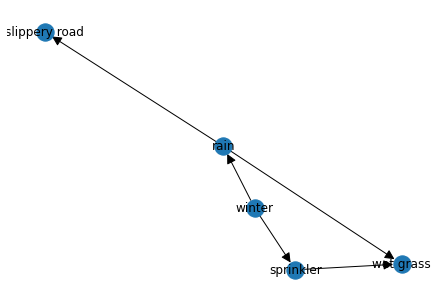

In [36]:
# Draw the Model
nx.draw(nx.DiGraph(edges),arrowsize=20, with_labels=True)
pylab.show()

In [37]:
# Create all the Conditional Probability Tables from the textbook example 
winter_cpd = TabularCPD('winter',2,[[0.6],
                                    [0.4]], state_names={"winter": [True, False]})
sprinkler_given_winter_cpd = TabularCPD('sprinkler',2,[[0.2,0.75],
                                                       [0.8,0.25]],
                                                       evidence=['winter'], evidence_card=[2], 
                                                       state_names={"sprinkler": [True, False], "winter": [True, False]})
rain_given_winter_cpd = TabularCPD('rain',2,[[0.8,0.1],
                                             [0.2,0.9]],
                                             evidence=['winter'], evidence_card=[2], 
                                             state_names={"rain": [True, False], "winter": [True, False]})
wg_given_rain_sprinkler_cpd = TabularCPD('wet grass',2,[[0.95,0.8,.9,0],
                                                        [0.05,0.2,.1,1]],
                                                        evidence=['rain', 'sprinkler'], evidence_card=[2,2], 
                                                        state_names={"wet grass": [True, False], "rain": [True, False], "sprinkler": [True, False]})
slippery_road_given_rain_cpd = TabularCPD('slippery road',2,[[0.7,0],
                                                             [0.3,1]],
                                                             evidence=['rain'], evidence_card=[2], 
                                                            state_names={"rain": [True, False], "slippery road": [True, False]})
all_cpds = [slippery_road_given_rain_cpd, wg_given_rain_sprinkler_cpd, rain_given_winter_cpd, sprinkler_given_winter_cpd, winter_cpd]

  

In [38]:
# Class will use the BayesianModel class from PGMPY 
bayes_network = BayesianModel(edges)
bayes_network.add_cpds(*all_cpds)

In [61]:
class Inference():

  def __init__(self, model):

    # Check if the model is an instance of BayesianModel
    if not isinstance(model, BayesianModel):
      raise ValueError(f"Model is a {type(model)} instance, not BayesianModel")
    else:
      self.model = model 
    self.cpds = model.get_cpds()
    self.joint_distribution = self.make_full_joint_distribution(self.cpds)

  def make_full_joint_distribution(self, cpds):
    # The joint distribution of the model is a probability table with all the 
    # variables in the model. Use DiscreteFactor
    phi1 = cpds[-1].to_factor()
    for cpd in cpds[:-1]:
      phi1.product(cpd.to_factor(), inplace=True)
    return phi1

  def query(self, query_variables=[], evidence={}):
    # Return the joint distribution if there is no query
    if not query_variables:
      return self.joint_distribution
    else:
      # Make sure the query variables are in the model
      for variable in query_variables:
        if variable not in self.model.nodes:
          raise ValueError(f"{variable} is not in the model")

    # Loop through the nodes to find ones not in query variables and evidence 
    # e.g. P(Y|X1) is the marginal sum of of all the variables in the model that 
    # are not Y and X1.
    non_query_variables = []
    for var in self.model.nodes: 
      if var not in query_variables and var not in evidence.keys():
        non_query_variables.append(var)

    # DiscreteFactor.reduce takes in values [(state, value), ....]
    evidence_list = [(state,val) for state,val in evidence.items()]
    # Collapse the full joint distribution on the evidence variables 
    reduced_factor = self.joint_distribution.reduce(evidence_list, inplace=False)
    # Marginzalize on the none query variables 
    marginal_factor = reduced_factor.marginalize(non_query_variables, inplace=False)
    return marginal_factor.normalize(inplace=False)

# Make an example inference to check with PGMPY Model
infer = Inference(model=bayes_network)
query = infer.query(['winter'], evidence={'rain':True, 'slippery road': False})
print(query)

+---------------+---------------+
| winter        |   phi(winter) |
+===============+===============+
| winter(True)  |        0.9231 |
+---------------+---------------+
| winter(False) |        0.0769 |
+---------------+---------------+


In [63]:
# Test custom class against PGMPY class
infer_pgmpy = VariableElimination(bayes_network)
query_pgmpy = infer_pgmpy.query(['winter'], evidence={'rain':True, 'slippery road': True})
print(query_pgmpy)

Eliminating: wet grass: 100%|██████████| 2/2 [00:00<00:00, 408.52it/s]

+---------------+---------------+
| winter        |   phi(winter) |
+===============+===============+
| winter(True)  |        0.9231 |
+---------------+---------------+
| winter(False) |        0.0769 |
+---------------+---------------+


In [64]:
# Results are the same 